This document demonstrate how to use the library to define a "density dependent population process" and to compute its mean-field approximation and refined mean-field approximation 

In [1]:
# To load the library
import src.rmf_tool as rmf


import importlib
importlib.reload(rmf)

# To plot the results
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

%matplotlib notebook


# Example : basic SIR model

Suppose that we want to simulate a model composed of $N$ agents where each agent has 3 possible states : $S$ (susceptible) $I$ (infected) and $R$ (recoverd). If we denote by $x_S$, $x_I$ and $x_S$ the population of agent and assume that : 
* A susceptible agent becomes infected at rate $x_S + 2x_Sx_I$
* An infected agent becomes recovered at rate $x_I$
* A recovered agent becomes susceptible at rate $3*x_R$

In terms of population process, we get the following transitions: 
* $x \mapsto x+\frac1N(-1,1,0)$ at rate $x_0+2x_0x_1$
* $x \mapsto x+\frac1N(0,-1,1)$ at rate $x_1$
* $x \mapsto x+\frac1N(1,0,-1)$ at rate $3x_2$

In [2]:
# This code creates an object that represents a "density dependent population process"
ddpp = rmf.DDPP() 
# We then add the three transitions : 
ddpp.add_transition([-1,1,0],lambda x:x[0]+2*x[0]*x[1])
ddpp.add_transition([0,-1,+1],lambda x:x[1])
ddpp.add_transition([1,0,-1],lambda x:3*x[2])


## Simulation and comparison with ODE
We can easily simulate one sample trajectory

### Simulation for various values of $N$

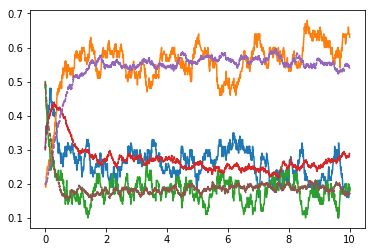

In [3]:
ddpp.set_initial_state([.3,.2,.5]) # We first need to define an initial stater
T,X = ddpp.simulate(100,time=10) # We first plot a trajectory for $N=100$
plt.plot(T,X)
T,X = ddpp.simulate(1000,time=10) # Then for $N=1000$
plt.plot(T,X,'--')

### Comparison with the ODE approximation 
We can easily compare simulations with the ODE approximation

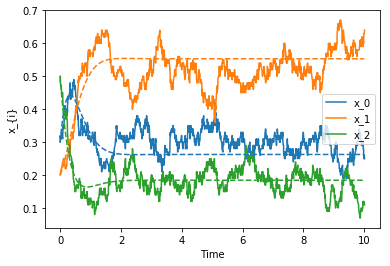

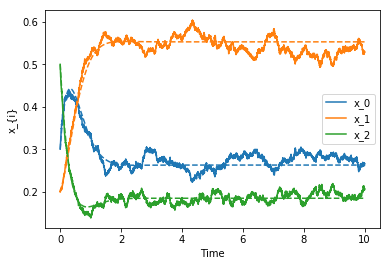

In [4]:
plt.figure()
ddpp.plot_ODE_vs_simulation(N=100)
plt.figure()
ddpp.plot_ODE_vs_simulation(N=1000)

## Refined mean-field approximation
(reference to be added)

This class also contains some functions to compute the fixed point of the mean-field approximation, to compute the "refined mean-field approximation" and to compare it with simulations. 

If $x$ is the fixed point of the ODE, and $C$ the constant calculated by the function "theoretical_C()", then we have 

$$E[X^N] = x + \frac1N C + o(\frac1N) $$

To compute these constants : 

In [5]:
x = ddpp.fixed_point()
%time V = ddpp.theoretical_V()
print(x,V)

CPU times: user 24 ms, sys: 534 µs, total: 24.6 ms
Wall time: 26.3 ms
[0.26259518 0.55305361 0.1843512 ] [ 0.15875529 -0.11906646 -0.03968882]


### Comparison of theoretical V and simulation 

We observe that, for this model, the mean-field approximation is already very close to the simulation. 

In [6]:
print(x,'(mean-field)')

for N in [10,50,100]:
    Xs,Vs = ddpp.steady_state_simulation(N=N,time=100000/N) 
    print(Xs,'(Simulation, N={})'.format(N)) 
    print('+/-',Vs)
    print(x+V/N,'(refined mean-field, N={})'.format(N))


[0.26259518 0.55305361 0.1843512 ] (mean-field)
[0.27815759 0.53884891 0.18094504] (Simulation, N=10)
+/- [0.00420433 0.00512749 0.00259401]
[0.27847071 0.54114697 0.18038232] (refined mean-field, N=10)
[0.26269104 0.55120105 0.18425991] (Simulation, N=50)
+/- [0.00412201 0.00463358 0.0024736 ]
[0.26577029 0.55067228 0.18355743] (refined mean-field, N=50)
[0.26527957 0.54849348 0.18386634] (Simulation, N=100)
+/- [0.00446736 0.00543592 0.00259814]
[0.26418274 0.55186295 0.18395432] (refined mean-field, N=100)


The function *compare_refinedMF* can be used to compare the refined mean-field "x+C/N" to the expectation of $X^N$. Note that the expectation is computed by using forward simulation up to time "time"; the value $E[X^N]$ is then the temporal average of $X^N(t)$ from t="time/2" to "time". (Hence, "time" should be manualy chosen so as to minimize the variance). 

In [7]:
Xm,Xrmf,Xs,Vs = ddpp.compare_refinedMF(N=10,time=10000)
print(Xm, 'mean-field')
print(Xrmf,'Refined mean-field')
print(Xs, 'Simulation')
print(Vs,'Confidence inverval of simulation (rough estimation)')

[0.26259518 0.55305361 0.1843512 ] mean-field
[0.27847071 0.54114697 0.18038232] Refined mean-field
[0.27746051 0.54062092 0.18007149] Simulation
[0.00475282 0.00555143 0.00280099] Confidence inverval of simulation (rough estimation)


# Transient analysis

Here we not not compare with simulation but just show how the vectors V(t) and A(t) can be computed. 

We observe that for this model the $O(1/N)$ and $O(1/N^2)$ expansions are very close. 

time to compute drift= 0.11407709121704102


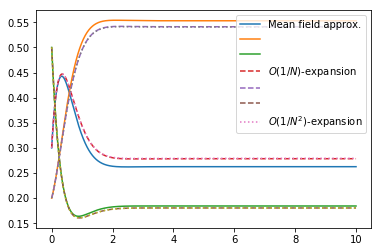

In [8]:
n=3
T,XVWABCD=ddpp.meanFieldExapansionTransient(order=2,time=10)
X = XVWABCD[:,0:n]
V = XVWABCD[:,n:2*n]
A = XVWABCD[:,2*n+n**2:3*n+n**2]


N=10
plt.figure()
plt.plot(T,X,'-')
plt.plot(T,X+V/N,'--')
plt.plot(T,X+V/N+A/N**2,':')
plt.legend(['Mean field approx.','','','$O(1/N)$-expansion','','','$O(1/N^2)$-expansion'])